In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
df_digest_protein = pd.read_csv('../data/uniprot/df_digest_protein_noptm.csv')

In [5]:
print(df_digest_protein.shape)
df_digest_protein.head(1)

(3925, 5)


,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
0,sp|Q9NP61|ARFG3_HUMAN,MGDPSKQDILTIFKRLRSVPTNKVCFDCGAKNPSWASITYGVFLCI...,>sp|Q9NP61|ARFG3_HUMAN ADP-ribosylation factor...,M_1;G_8;D_0;P_5;S_0;K_0;Q_5;D_2;I_2;L_2;T_2;I_...,M_1;G_9;D_9;P_14;S_14;K_14;Q_17;D_17;I_17;L_17...


# Digestibility Modeling
  - labelling followed AP3 paper

In [6]:
def labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD = 4):  # prot2cnt, prot2cnt_miss must be list split by ;

    ts2label = dict()
    # protein loop
    for idx in range(len(prot2cnt)):
        # amino acid loop in one protein
        for amino_idx in range(len(prot2cnt[idx])):
            # tryptic site : K, R
            if prot2cnt[idx][amino_idx][:1] in 'KR':
                
                # *******TRYPTIC SITE EXTRACTING FROM PROTEIN*******
                # tryptic site in protein N-terminal
                if amino_idx <= THRESHOLD - 1:
                    tryptic_site = 'Z'*(THRESHOLD-amino_idx) + ''.join([a[0] for a in prot2cnt[idx][: amino_idx+THRESHOLD + 1]])  # added Z
                # tryptic site in protein C-terminal
                elif amino_idx >= len(prot2cnt[idx]) - THRESHOLD:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]]) + 'Z'*(THRESHOLD-(len(prot2cnt[idx])-1)+amino_idx)  # added Z
                else:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]])

                    
                # *******TRYPTIC SITE LABELLING (WHEN POSITIVE)*******
                # N-terminal of tryptic site condition
                N_Pcondition = int(prot2cnt[idx][amino_idx][2:]) >= 1
                # C-terminal of tryptic site condition
                if amino_idx == len(prot2cnt[idx]) - 1:  # tryptic site in last position of protein
                    C_prot2cntondition = True
                else:
                    C_prot2cntondition = int(prot2cnt[idx][amino_idx + 1][2:]) >= 1
                # miss cleavage of tryptic site contidion
                miss_prot2cntondition = int(prot2cnt_miss[idx][amino_idx][2:]) == 0
                # True of all above, Positive labeling
                P_condition = (N_Pcondition == True) and (C_prot2cntondition == True) and (miss_prot2cntondition == True)

                # *******TRYPTIC SITE LABELLING (WHEN NEGATIVE)*******
                # N-terminal of tryptic site condition
                N_NCondition = int(prot2cnt[idx][amino_idx][2:]) == 0
                # C-terminal of tryptic site condition
                if amino_idx == len(prot2cnt[idx]) - 1:  # tryptic site in last position of protein
                    C_NCondition = False
                else:
                    C_NCondition = int(prot2cnt[idx][amino_idx + 1][2:]) == 0
                # miss cleavage of tryptic site condition
                miss_Ncondition = int(prot2cnt_miss[idx][amino_idx][2:]) >= 1
                # True of all above, Negative labeling
                N_condition = (N_NCondition == True) and (C_NCondition == True) and (miss_Ncondition == True)

                # *******MAKING DATASET*******
                if P_condition:
                    if tryptic_site not in ts2label:
                        ts2label[tryptic_site] = []
                    ts2label[tryptic_site].append(('P', idx, amino_idx))
                elif N_condition:
                    if tryptic_site not in ts2label:
                        ts2label[tryptic_site] = []
                    ts2label[tryptic_site].append(('N', idx, amino_idx))
    
    # *******JUST FOR COUNTING*******
    p = [k for k, v in ts2label.items() if v[0][0]=='P']
    n = [k for k, v in ts2label.items() if v[0][0]=='N']
    print(' P, unique p: {} \n n, unique n: {} \n total : {:,}'.format(
         (len(p), len(set(p))), 
         (len(n), len(set(n))), 
         len(p)+len(n)))
    df = pd.DataFrame({'tryptic_site':p+n, 'label':['P' if i in p else 'N' for i in p+n]})
    return df, ts2label

In [7]:
prot2cnt = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT.values]
prot2cnt_miss = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT_MISS.values]

In [8]:
df_digest, ts2label = labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD=4)  # ts2label is just for checking

 P, unique p: (21382, 21382) 
 n, unique n: (9076, 9076) 
 total : 30,458


* train digestibility model

In [9]:
def onehot_enc(aa):
    return [1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ']

In [10]:
X = np.array([[__ for _ in ts for __ in onehot_enc(_)] for ts in df_digest.tryptic_site.values])
y = df_digest.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=77)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X_train, y_train)

(30458, 189) (30458,) (22843, 189) (7615, 189) (22843,) (7615,)


RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [11]:
y_pred = RF_digest.predict(X_test)
print(classification_report(y_test, y_pred))
probs = RF_digest.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('AUC : {}'.format(rf_auc))

              precision    recall  f1-score   support

           N       0.87      0.67      0.76      2241
           P       0.88      0.96      0.91      5374

    accuracy                           0.87      7615
   macro avg       0.87      0.82      0.84      7615
weighted avg       0.87      0.87      0.87      7615

AUC : 0.9143973653369629


In [12]:
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X, y)  # for adjusting Detectability

RandomForestClassifier(max_features='sqrt', n_estimators=200)

# Detectability
  - large dataset

In [13]:
def cal_digestibility(seq_li, model):
    noseq_idx = [idx for idx, _ in enumerate(seq_li) if _ == '-']
    X = np.array([[__ for _ in seq for __ in onehot_enc(_)] if seq != '-' else [0]*189 for seq in seq_li])
    y_pred = model.predict_proba(X)[:, 1]  # positive probability = digestibility
    y_pred[noseq_idx] = 1
    return y_pred

In [14]:
def labelling_detect(df, aa2val, RF_digest):
    df_ = df.copy()
    # set tryptic site 9mer
    df_['miss'] = [sum([1 for _ in p[:-1] if _ in 'KR']) for p in df_.PEP.values]
    df_['En'] = df_.En.apply(lambda x: x[3:-3]).values
    df_['Ec'] = df_.Ec.apply(lambda x: x[3:-3]).values
    df_['E1'] = df_.E1.apply(lambda x: x[3:-3] if x != '-' else '-').values
    df_['E2'] = df_.E2.apply(lambda x: x[3:-3] if x != '-' else '-').values

    # digestibility
    score_n = cal_digestibility(df_.En.values, RF_digest)
    score_c = cal_digestibility(df_.Ec.values, RF_digest)
    score_m1 = cal_digestibility(df_.E1.values, RF_digest)
    score_m2 = cal_digestibility(df_.E2.values, RF_digest)
    df_['digestibility'] = score_n * score_c * score_m1 * score_m2
    
    # get AA index
    cols = list(range(21+len(aa2val['A'])))  # aa_cnt + aa_index length sum 
    cols_value = []
    for seq in df_.PEP.values:
        aa_cnt = [seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ']
        aa_index = list(np.array([aa2val[aa] for aa in seq]).sum(axis=0))
        cols_value.append(aa_cnt+aa_index)
    df_[cols] = cols_value

    df_.drop(['peptide', 'En', 'Ec', 'E1', 'E2', 'protein', 'PEP'], axis=1, inplace=True)
    return df_

In [24]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

# AA index
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex.csv')
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

In [25]:
train = labelling_detect(df_detect_peptide_train, aa2val, RF_digest)

In [27]:
from mrmr import mrmr_classif

X = train.drop('ID', axis=1)
y = train.ID

# use mrmr classification
selected_features = mrmr_classif(X, y, K = 50)

100%|██████████| 50/50 [02:21<00:00,  2.82s/it]


In [28]:
df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
train_idx = df_detect_peptide_train.shape[0]
df_ = labelling_detect(df, aa2val, RF_digest)

train_final = df_.iloc[:train_idx]
test_final = df_.iloc[train_idx:]

cols = selected_features[:29] + ['ID']
train = train_final[cols]
test = test_final[cols]

In [29]:
X_train = train.drop('ID', axis=1).values
y_train = train.ID.values
X_test = test.drop('ID', axis=1).values
y_test = test.ID.values
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(421474, 29) (88998, 29) (421474,) (88998,)


In [48]:
RF_detect = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_detect.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=200)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     44509
           1       0.80      0.88      0.84     44489

    accuracy                           0.83     88998
   macro avg       0.83      0.83      0.83     88998
weighted avg       0.83      0.83      0.83     88998

rf auc : 0.9134609907642045


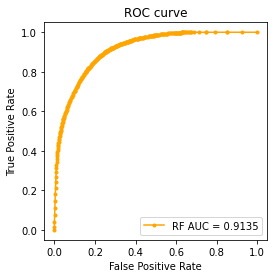

In [31]:
# prediction
y_pred = RF_detect.predict(X_test)
print(classification_report(y_test, y_pred))

# AUC
probs = RF_detect.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Detectability
 - original

(177997, 29) (44499, 29) (177997,) (44499,)
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     22330
           1       0.81      0.86      0.83     22169

    accuracy                           0.83     44499
   macro avg       0.83      0.83      0.83     44499
weighted avg       0.83      0.83      0.83     44499

rf auc : 0.9126150262435632


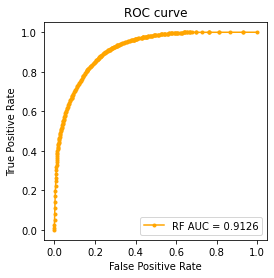

In [32]:
df_detect_peptide_train_ori = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_detect_peptide_test_ori = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

df = pd.concat([df_detect_peptide_train_ori, df_detect_peptide_test_ori], axis=0)
train_idx = df_detect_peptide_train_ori.shape[0]
df_ = labelling_detect(df, aa2val, RF_digest)
train_final = df_.iloc[:train_idx]
test_final = df_.iloc[train_idx:]
cols = selected_features[:29] + ['ID']
train = train_final[cols]
test = test_final[cols]

X_train_ori = train.drop('ID', axis=1).values
y_train_ori = train.ID.values
X_test_ori = test.drop('ID', axis=1).values
y_test_ori = test.ID.values
print(X_train_ori.shape, X_test_ori.shape, y_train_ori.shape, y_test_ori.shape)

RF_detect_ori = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_detect_ori.fit(X_train_ori, y_train_ori)

# prediction
y_pred = RF_detect_ori.predict(X_test_ori)
print(classification_report(y_test_ori, y_pred))

# AUC
probs = RF_detect_ori.predict_proba(X_test_ori)[:, 1]
rf_auc = roc_auc_score(y_test_ori, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test_ori, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [47]:
ori = []
large=[]
for o, l in zip(X_test_ori, X_test):
    o = ';'.join(list(map(str, o)))
    l = ';'.join(list(map(str, l)))
    if o == l:
        ori.append(o)
        large.append(l)

print(X_test_ori.shape[0], X_test.shape[0], len(ori)) # ori_set이 large_set에 다 포함됨

44499 88998 44499


              precision    recall  f1-score   support

           0       0.86      0.78      0.82     22330
           1       0.80      0.87      0.83     22169

    accuracy                           0.83     44499
   macro avg       0.83      0.83      0.83     44499
weighted avg       0.83      0.83      0.83     44499

rf auc : 0.9130748958803356


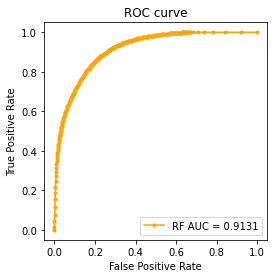

In [49]:
# prediction
y_pred = RF_detect.predict(X_test_ori)
print(classification_report(y_test_ori, y_pred))
# AUC
probs = RF_detect.predict_proba(X_test_ori)[:, 1]
rf_auc = roc_auc_score(y_test_ori, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test_ori, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# 비슷하므로 largedataset사용해도 되겠다.

# tool result ....ㅋ

In [52]:
ap3_result = pd.read_csv('../data/uniprot/DetectabilitiesOfPeptides.txt', sep='\t')

In [60]:
ap3_common = ap3_result.merge(df_detect_peptide_test_ori, left_on=['Protein id', 'Peptide sequence'], right_on=['protein', 'PEP'], how='inner')
ap3_pred = ap3_common['Peptide detectability'].values

In [76]:
# prediction
ap3_p = np.array([1 if _>=0.5 else 0 for _ in ap3_pred])
print(classification_report(y_test_ori, ap3_p))

              precision    recall  f1-score   support

           0       0.50      0.57      0.54     22330
           1       0.50      0.43      0.46     22169

    accuracy                           0.50     44499
   macro avg       0.50      0.50      0.50     44499
weighted avg       0.50      0.50      0.50     44499



rf auc : 0.49878438697222616


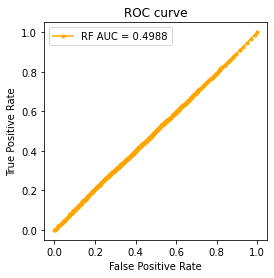

In [77]:
# AUC
rf_auc = roc_auc_score(y_test_ori, ap3_pred)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test_ori, ap3_pred)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [79]:
ap3_common.head(50)

,Peptide sequence,Protein id,Peptide detectability,peptide,En,Ec,E1,E2,protein,PEP,ID
0,NTLYLQMGSLR,sp|A0A075B6Q5|HV364_HUMAN,0.95000,K.NTLYLQMGSLR.A,TISRDNSKNTLYLQM,YLQMGSLRAEDMAVY,-,-,sp|A0A075B6Q5|HV364_HUMAN,NTLYLQMGSLR,1
1,AEAPPGSK,sp|A0A087WXM9|MEIKN_HUMAN,0.75000,K.AEAPPGSK.R,PDLGSPAKAEAPPGS,AEAPPGSKRKGKVHG,-,-,sp|A0A087WXM9|MEIKN_HUMAN,AEAPPGSK,0
2,APQFSNVSAIFSTSSEDYQK,sp|A0A087WXM9|MEIKN_HUMAN,0.93500,K.APQFSNVSAIFSTSSEDYQK.C,SKAVAIEKAPQFSNV,TSSEDYQKCHRKTVM,-,-,sp|A0A087WXM9|MEIKN_HUMAN,APQFSNVSAIFSTSSEDYQK,1
3,DTPQDIIIK,sp|A0A087WXM9|MEIKN_HUMAN,0.73000,K.DTPQDIIIK.M,KKKYSLPKDTPQDII,TPQDIIIKMAZZZZZ,-,-,sp|A0A087WXM9|MEIKN_HUMAN,DTPQDIIIK,1
4,LGVTGEKSLQENR,sp|A0A087WXM9|MEIKN_HUMAN,0.09500,R.LGVTGEKSLQENR.S,GSGPFSPRLGVTGEK,EKSLQENRSSEDTQD,RLGVTGEKSLQENRS,-,sp|A0A087WXM9|MEIKN_HUMAN,LGVTGEKSLQENR,1
5,SFEESFPSPELFRK,sp|A0A087WXM9|MEIKN_HUMAN,0.59000,K.SFEESFPSPELFRK.S,TDSYAEYKSFEESFP,PSPELFRKSDYLDWE,FPSPELFRKSDYLDW,-,sp|A0A087WXM9|MEIKN_HUMAN,SFEESFPSPELFRK,1
6,APQFSNVSAIFSTSSEDYQKCHR,sp|A0A087WXM9|MEIKN_HUMAN,0.47000,K.APQFSNVSAIFSTSSEDYQKCHR.K,SKAVAIEKAPQFSNV,EDYQKCHRKTVMTVA,TSSEDYQKCHRKTVM,-,sp|A0A087WXM9|MEIKN_HUMAN,APQFSNVSAIFSTSSEDYQKCHR,0
7,REGQRLNLTPTPDLGSPAK,sp|A0A087WXM9|MEIKN_HUMAN,0.10000,K.REGQRLNLTPTPDLGSPAK.A,LRVYTRKKREGQRLN,PDLGSPAKAEAPPGS,RVYTRKKREGQRLNL,RKKREGQRLNLTPTP,sp|A0A087WXM9|MEIKN_HUMAN,REGQRLNLTPTPDLGSPAK,0
8,QVKNKGVIVK,sp|A0A087WXM9|MEIKN_HUMAN,0.07000,R.QVKNKGVIVK.K,IRTSPGTRQVKNKGV,KNKGVIVKKKKYSLP,SPGTRQVKNKGVIVK,GTRQVKNKGVIVKKK,sp|A0A087WXM9|MEIKN_HUMAN,QVKNKGVIVK,0
9,DPALTVDLGDSEK,sp|A0A096LP49|CC187_HUMAN,0.78000,R.DPALTVDLGDSEK.V,HHSKDPSRDPALTVD,VDLGDSEKVIAAKCS,-,-,sp|A0A096LP49|CC187_HUMAN,DPALTVDLGDSEK,1
